In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix as cf_matrix

In [26]:
corp = 'nzl'

In [27]:
df = pd.read_json(corp + '_topic_df.json')

In [28]:
len(df)

444080

In [ ]:
# Lengths of each dataframe:
# aut: 86067, czc: 195470, den: 438115, deu: 188664, eng: 1459922, esp: 93493, nld: 740015, nzl: 444080, swe: 354030

In [29]:
# Total number of speeches
86067 + 195470 + 438115 + 188664 + 1459922 + 93493 + 740015 + 444080 + 354030

3999856

In [104]:
# 'if corp == 'eng':
#     # https://www.parliament.uk/about/faqs/house-of-commons-faqs/business-faq-page/recess-dates/list-of-previous-commons-recess-dates/
#     df['session'] = '1988-89'
#     df.loc[df['date'] >= datetime.datetime(1989, 11, 21), 'session'] = '1989-90'
#     df.loc[df['date'] >= datetime.datetime(1990, 11, 7), 'session'] = '1990-91'
#     df.loc[df['date'] >= datetime.datetime(1991, 10, 31), 'session'] = '1991-92'
#     df.loc[df['date'] >= datetime.datetime(1992, 5, 6), 'session'] = '1992-93'
#     df.loc[df['date'] >= datetime.datetime(1993, 11, 18), 'session'] = '1993-94'
#     df.loc[df['date'] >= datetime.datetime(1994, 11, 16), 'session'] = '1994-95'
#     df.loc[df['date'] >= datetime.datetime(1995, 11, 15), 'session'] = '1995-96'
#     df.loc[df['date'] >= datetime.datetime(1996, 10, 23), 'session'] = '1996-97'
#     df.loc[df['date'] >= datetime.datetime(1997, 5, 14), 'session'] = '1997-98'
#     df.loc[df['date'] >= datetime.datetime(1998, 11, 24), 'session'] = '1998-99'
#     df.loc[df['date'] >= datetime.datetime(1999, 11, 24), 'session'] = '1999-00'
#     df.loc[df['date'] >= datetime.datetime(2000, 12, 6), 'session'] = '2000-01'
#     df.loc[df['date'] >= datetime.datetime(2001, 6, 20), 'session'] = '2001-02'
#     df.loc[df['date'] >= datetime.datetime(2002, 11, 13), 'session'] = '2002-03'
#     df.loc[df['date'] >= datetime.datetime(2003, 11, 26), 'session'] = '2003-04'
#     df.loc[df['date'] >= datetime.datetime(2004, 11, 23), 'session'] = '2004-05'
#     df.loc[df['date'] >= datetime.datetime(2005, 5, 17), 'session'] = '2005-06'
#     df.loc[df['date'] >= datetime.datetime(2006, 11, 15), 'session'] = '2006-07'
#     df.loc[df['date'] >= datetime.datetime(2007, 11, 6), 'session'] = '2007-08'
#     df.loc[df['date'] >= datetime.datetime(2008, 12, 3), 'session'] = '2008-09'
#     df.loc[df['date'] >= datetime.datetime(2009, 11, 18), 'session'] = '2009-10'
#     df.loc[df['date'] >= datetime.datetime(2010, 5, 25), 'session'] = '2010-11'
#     df.loc[df['date'] >= datetime.datetime(2011, 5, 24), 'session'] = '2011-12'
#     df.loc[df['date'] >= datetime.datetime(2012, 5, 9), 'session'] = '2012-13'
#     df.loc[df['date'] >= datetime.datetime(2013, 5, 8), 'session'] = '2013-14'
#     df.loc[df['date'] >= datetime.datetime(2014, 6, 4), 'session'] = '2014-15'
#     df.loc[df['date'] >= datetime.datetime(2015, 5, 27), 'session'] = '2015-16'
#     df.loc[df['date'] >= datetime.datetime(2016, 5, 18), 'session'] = '2016-17'
#     df.loc[df['date'] >= datetime.datetime(2017, 6, 21), 'session'] = '2017-19' # NB! 2017-2019 is unusually long
#     df.loc[df['date'] >= datetime.datetime(2019, 10, 14), 'session'] = '2019' # NB! Unusually short, only 15 days
# elif corp == 'nzl':
#     # Working years typically correspond to calendar years.
#     df['session'] = df['year']
# else:
#     print('SO STUPID SET CORP')
#     '

In [105]:
# Vectorizing 
vectorizer = TfidfVectorizer(min_df= 0.0001) # Default N-gram range is (1,1) Maybe change?

In [106]:
def preprocess(text):
    'Creating preprocessing pipeline'

    # Lowercasing
    text = text.lower()

    # Removing punctuation
    text = re.sub(r'[()\.\,\?\!\"\'\-\`\:\;\\\%\*\[\]]+','', text)

    return text

In [107]:
# Learning curve plotter
def plot_curve(train_scores, val_scores, train_sizes):
    """A helper function to plot the train scores array
    against the validation scores"""

    # Calculate the values to plot

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning and cross-validation curve

    plt.rcParams['font.size'] = '16'
    fig, ax = plt.subplots( figsize=(14,6) )
#     plt.xlim([3000, 12000])
#     plt.ylim([0.4, 1.0])
    plt.plot(train_sizes, train_mean, color='red', marker='o', markersize=5, label='Training Accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='red')
    plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Model accuracy')
    plt.grid()
    plt.legend(loc='lower right')

In [108]:
# Results and Confusion Matrix
group_names = ['True Negative', 'False Positive', 'True Positive', 'False Negative']
categories = ['Zero', 'One']
def confusion_matrix(cf,
                     group_names=None,
                     categories='auto',
                     count=True,
                     percent=True,
                     cbar=True,
                     xyticks=True,
                     xyplotlabels=True,
                     sum_stats=True,
                     figsize=None,
                     cmap='Blues',
                     title=None):
  '''
      This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
      Source: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
  '''


  # CODE TO GENERATE TEXT INSIDE EACH SQUARE
  blanks = ['' for i in range(cf.size)]

  if group_names and len(group_names)==cf.size:
      group_labels = ["{}\n".format(value) for value in group_names]
  else:
      group_labels = blanks

  if count:
      group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
  else:
      group_counts = blanks

  if percent:
      group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
  else:
      group_percentages = blanks

  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

  # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
  if sum_stats:
    #Accuracy is sum of diagonal divided by total observations
    accuracy  = np.trace(cf) / float(np.sum(cf))
    #auc = roc_auc_score()

    #if it is a binary confusion matrix, show some more stats
    if len(cf)==2:
        #Metrics for Binary Confusion Matrices
        precision = cf[1,1] / sum(cf[:,1])
        recall    = cf[1,1] / sum(cf[1,:])
        f1_score  = 2*precision*recall / (precision + recall)
        stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
            accuracy,precision,recall,f1_score)
    else:
        stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
  else:
      stats_text = ""

  # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
  if figsize==None:
      #Get default figure size if not set
      figsize = plt.rcParams.get('figure.figsize')

  if xyticks==False:
      #Do not show categories if xyticks is False
      categories=False


  # MAKE THE HEATMAP VISUALIZATION
  plt.figure(figsize=figsize)
  sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

  if xyplotlabels:
      plt.ylabel('True label')
      plt.xlabel('Predicted label' + stats_text)
  else:
      plt.xlabel(stats_text)

  if title:
      plt.title(title)


In [109]:
def binary_classifier(train_features, train_labels, validation_features, validation_labels):
#   param_grid = {'C': [1]} # NB! Change to proper grid when not testing!
  param_grid = {'C': [1,1.6,1.8,2, 3,6,10]}
  grid = GridSearchCV(LogisticRegression(max_iter=2500, penalty='l2', class_weight= 'balanced'), param_grid, cv=5, verbose = 1)
  grid.fit(train_features, train_labels)

  # defining the incremental 10% splits for the learning curve
  train_sizes = list(np.arange(0.1,1.1,0.1).round(1))
# logistic regression with 10-fold cross-validation over training data

  train_sizes, train_scores, cv_scores = learning_curve(estimator = grid.best_estimator_,
                                                        X = train_features, 
                                                        y = train_labels,
                                                        train_sizes = train_sizes, # the train sizes we have defined above
                                                        cv = 5 ,
                                                        n_jobs = -1) # 5-fold cross-validation
#   plot_curve(train_scores, cv_scores, train_sizes)
#   plt.show()

  
  # Create logistic regression object
  lr = grid.best_estimator_

# Train the model using the training sets
  lr.fit(train_features, train_labels)

# Make predictions using the validation set and train set
  validation_pred = lr.predict_proba(validation_features)
  train_pred = lr.predict_proba(train_features)

# Confusion matrix
#   confusion_matrix(cf_matrix(validation_pred,validation_labels))

#   classification_report(validation_labels, validation_pred)

# Return predictions for later use
  return train_pred, validation_pred, #classification_report(validation_labels, validation_pred, output_dict = True)['accuracy']

In [113]:
wid_df = pd.read_csv(r"/maps/hdir/gsw508/Thesis//Data/WID_Data_12042023-120615.csv", sep = ';', header = 1)

if corp == 'aut': 
    reg_df = wid_df[['Year','sptinc_z_AT\nPre-tax national income \nTop 10% | share\nAustria']]
    reg_df = reg_df.rename(columns = {'sptinc_z_AT\nPre-tax national income \nTop 10% | share\nAustria': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))] 

elif corp == 'czc': 
    reg_df = wid_df[['Year','sptinc_z_CZ\nPre-tax national income \nTop 10% | share\nCzech Republic']]
    reg_df = reg_df.rename(columns = {'sptinc_z_CZ\nPre-tax national income \nTop 10% | share\nCzech Republic': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))]
    
elif corp == 'den': 
    reg_df = wid_df[['Year','sptinc_z_DK\nPre-tax national income \nTop 10% | share\nDenmark']]
    reg_df = reg_df.rename(columns = {'sptinc_z_DK\nPre-tax national income \nTop 10% | share\nDenmark': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))] 
    
elif corp == 'deu': 
    reg_df = wid_df[['Year','sptinc_z_DE\nPre-tax national income \nTop 10% | share\nGermany']]
    reg_df = reg_df.rename(columns = {'sptinc_z_DE\nPre-tax national income \nTop 10% | share\nGermany': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))] 
    
elif corp == 'eng': 
    reg_df = wid_df[['Year','sptinc_z_GB\nPre-tax national income \nTop 10% | share\nUnited Kingdom']]
    reg_df = reg_df.rename(columns = {'sptinc_z_GB\nPre-tax national income \nTop 10% | share\nUnited Kingdom': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min() + 1, df.year.max() + 1))] # NB! 1988 excluded
    
elif corp == 'esp': 
    reg_df = wid_df[['Year','sptinc_z_ES\nPre-tax national income \nTop 10% | share\nSpain']]
    reg_df = reg_df.rename(columns = {'sptinc_z_ES\nPre-tax national income \nTop 10% | share\nSpain': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))] 
    
elif corp == 'ndl': 
    reg_df = wid_df[['Year','sptinc_z_NL\nPre-tax national income \nTop 10% | share\nNetherlands']]
    reg_df = reg_df.rename(columns = {'sptinc_z_NL\nPre-tax national income \nTop 10% | share\nNetherlands': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min() + 1, df.year.max() + 1))] # NB! 1994 excluded
    
elif corp == 'nzl':
    reg_df = wid_df[['Year','sptinc_z_NZ\nPre-tax national income \nTop 10% | share\nNew Zealand']]
    reg_df = reg_df.rename(columns = {'sptinc_z_NZ\nPre-tax national income \nTop 10% | share\nNew Zealand': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min(), df.year.max() + 1))]
    
elif corp == 'swe': 
    reg_df = wid_df[['Year','sptinc_z_SE\nPre-tax national income \nTop 10% | share\nSweden']]
    reg_df = reg_df.rename(columns = {'sptinc_z_SE\nPre-tax national income \nTop 10% | share\nSweden': 'Inequality'})
    reg_df = reg_df.loc[reg_df['Year'].isin(range(df.year.min() + 1, df.year.max() + 1))] # NB! 1990 excluded
    
else:
    print('SO STUPID SET CORP')

In [114]:
# reg_df = pd.read_json(corp + '_reg_df.json')

  0%|                                                     | 0/6 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates

 17%|███████▎                                    | 1/6 [04:14<21:12, 254.59s/it]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates

 33%|██████████████▋                             | 2/6 [05:25<09:46, 146.64s/it]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates

 50%|██████████████████████                      | 3/6 [06:48<05:53, 117.68s/it]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
7 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/unicph.domain/gsw508/anaconda3/lib/pyt

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1646: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 9 instead of 10.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1646: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 9 instead of 10.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1646: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 8 instead of 10.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1646: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 5 instead of 10.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/home/unicph.domain/gsw508/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:1646: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 7 instead of 10.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits


 67%|██████████████████████████████               | 4/6 [07:04<02:35, 77.57s/it]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates

 83%|█████████████████████████████████████▌       | 5/6 [08:59<01:31, 91.05s/it]

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 7 candidates

100%|█████████████████████████████████████████████| 6/6 [09:57<00:00, 99.55s/it]


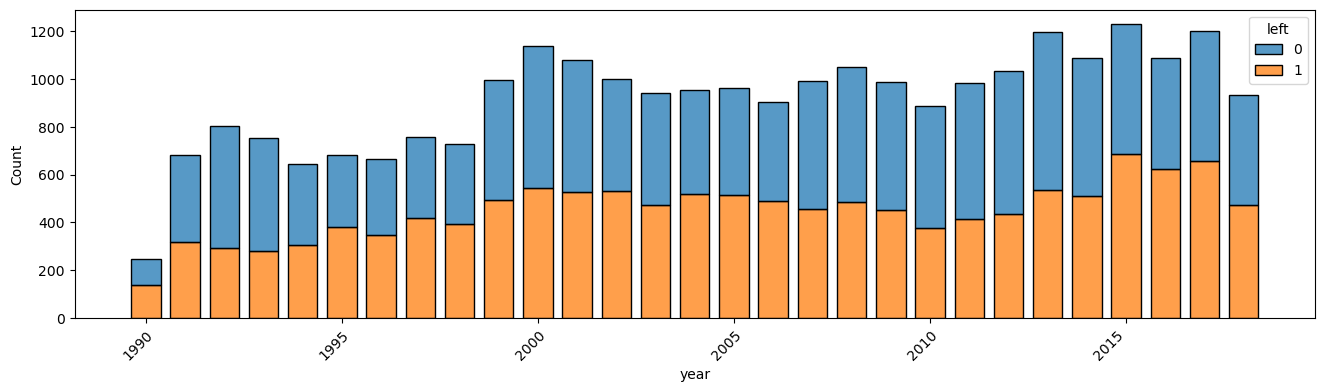

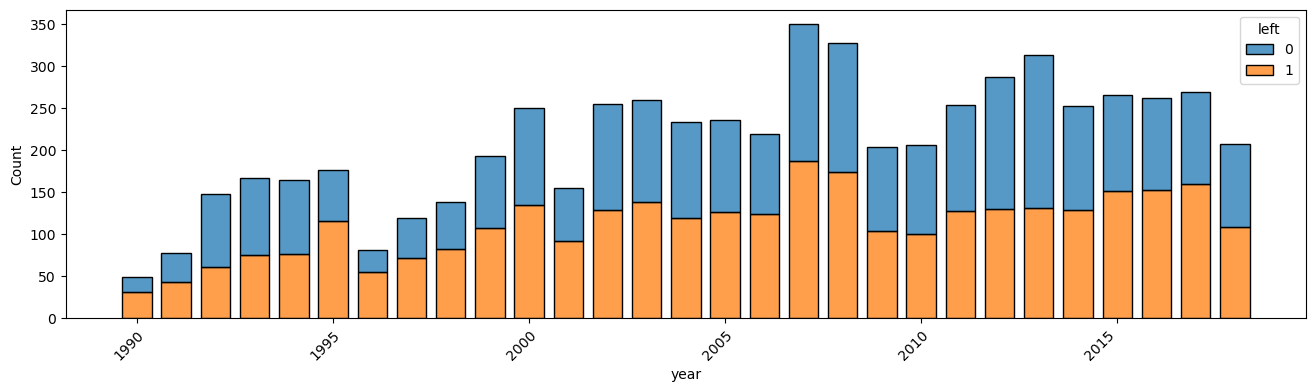

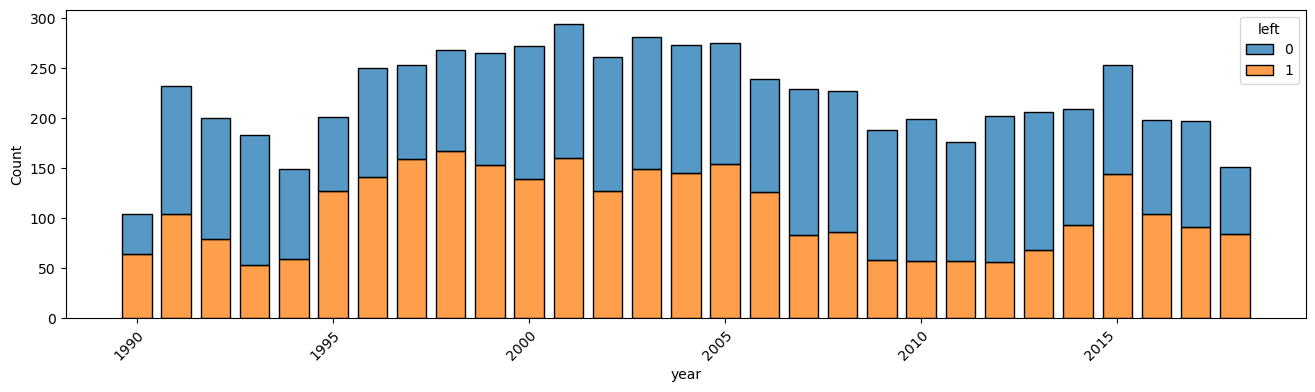

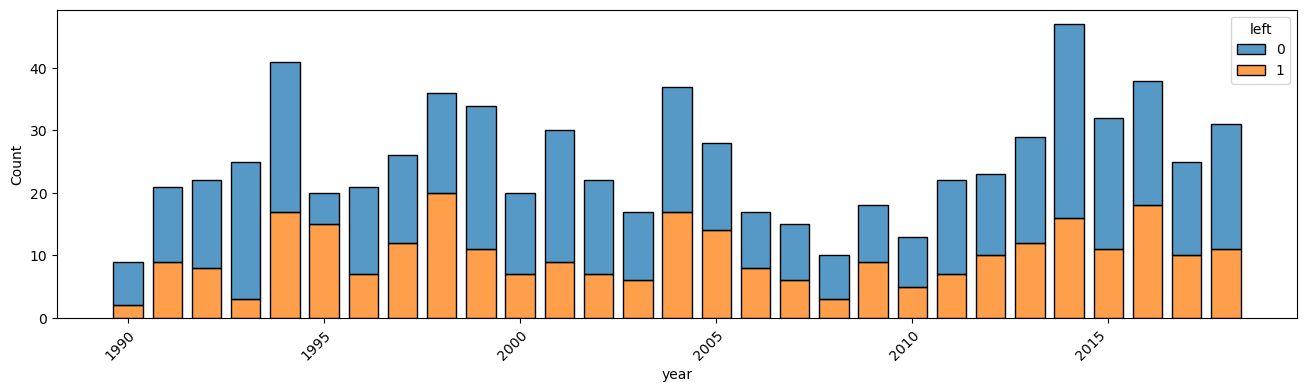

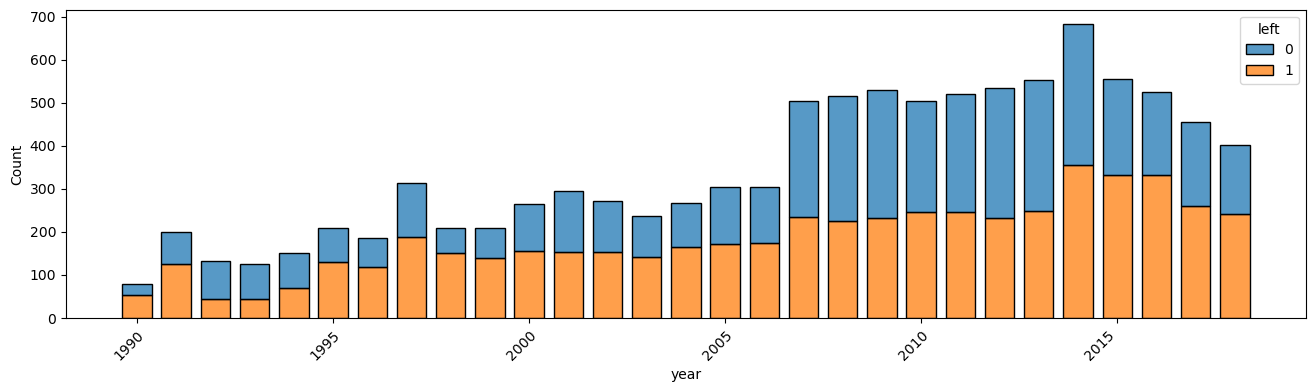

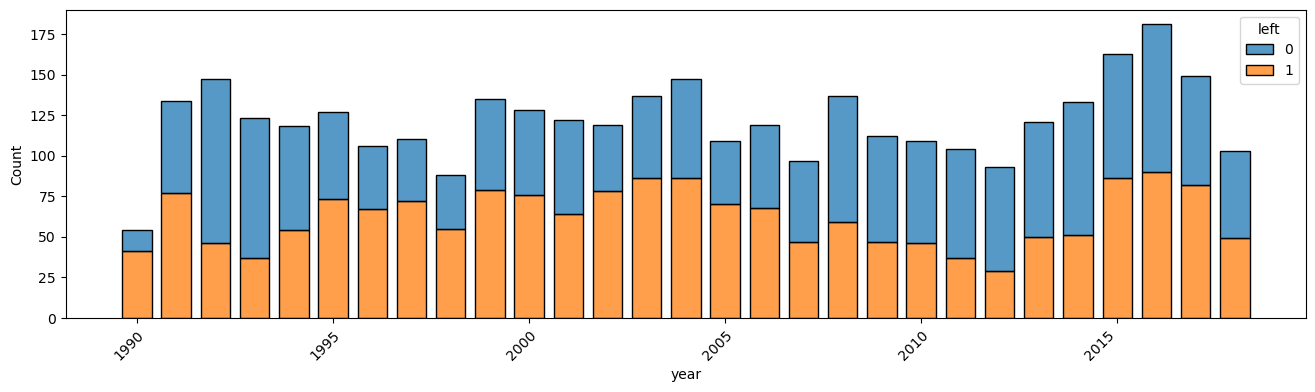

In [115]:
topic_list = ['soc', 'rel', 'eth', 'urb', 'pos', 'for']

for topic in tqdm(topic_list):
    # Create topic dataframe and remove speeches without speaker
    topic_df = df.loc[df[topic] == 1]
    topic_df = topic_df.loc[topic_df['speaker'].notna()]
    
    # Plot distribution
    fig, ax1 = plt.subplots(figsize=(16, 4))
    plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor');

    sns.histplot(x = 'year', data = topic_df, hue = 'left', discrete = True, multiple = 'stack', shrink = 0.75);
    
    # Find distribution (total and left) and run classification for each year
    acc_dict = {}
    tot_dist_dict = {}
    left_dist_dict = {}
    for year in reg_df['Year']:

        # Assign year and preprocess
        topic_year_df = topic_df.loc[topic_df['year'] == year]
        topic_df_prepro = topic_year_df['text'].apply(lambda x: preprocess(x))

        # Split to train and test
        X_train, X_validation, Y_train, Y_validation = train_test_split(topic_df_prepro, topic_year_df['left'], random_state = 0)
        X_train_features = vectorizer.fit_transform(X_train)
        X_validation_features = vectorizer.transform(X_validation)

        # Train classifier for year
        train_pred, validation_pred = binary_classifier(X_train_features,
                                                        Y_train,
                                                        X_validation_features,
                                                        Y_validation)

        # Get probabilities for each speech given by each MP
        mp_pred_dict = {key: [] for key in topic_year_df['speaker'][X_validation.keys()].unique()}

        for i in range(0, len(validation_pred)):
            mp_pred_dict[topic_year_df['speaker'][Y_validation.index[i]]].append(validation_pred[i][1])

        # Get overall prediction for each MP
        mp_pred_dict = {key: round(np.mean(mp_pred_dict[key])) for key in mp_pred_dict}

        # Find accuracy of MP predictions
        true_list = []
        for i in range(0, len(mp_pred_dict)):
            true_list.append(topic_year_df.loc[topic_year_df['speaker'] == list(mp_pred_dict.keys())[i], 'left'].values[0])

        acc_dict[year] = accuracy_score(true_list, list(mp_pred_dict.values()))
        tot_dist_dict[year] = (len(topic_df.loc[(topic_df['year'] == year) & (topic_df[topic] == 1) & (topic_df['year'] == year)]))
        left_dist_dict[year] = (len(topic_df.loc[(topic_df['year'] == year) & (topic_df[topic] == 1) & (topic_df['year'] == year) & (topic_df['left'] == 1)]))
        
    # Add scores to reg_df, and save as json
    reg_df[topic + ' Polarisation'] = acc_dict.values()
    reg_df[topic + ' Total Distribution'] = tot_dist_dict.values()
    reg_df[topic + ' Left Distribution'] = left_dist_dict.values()
    reg_df.to_json(corp + '_reg_df.json')

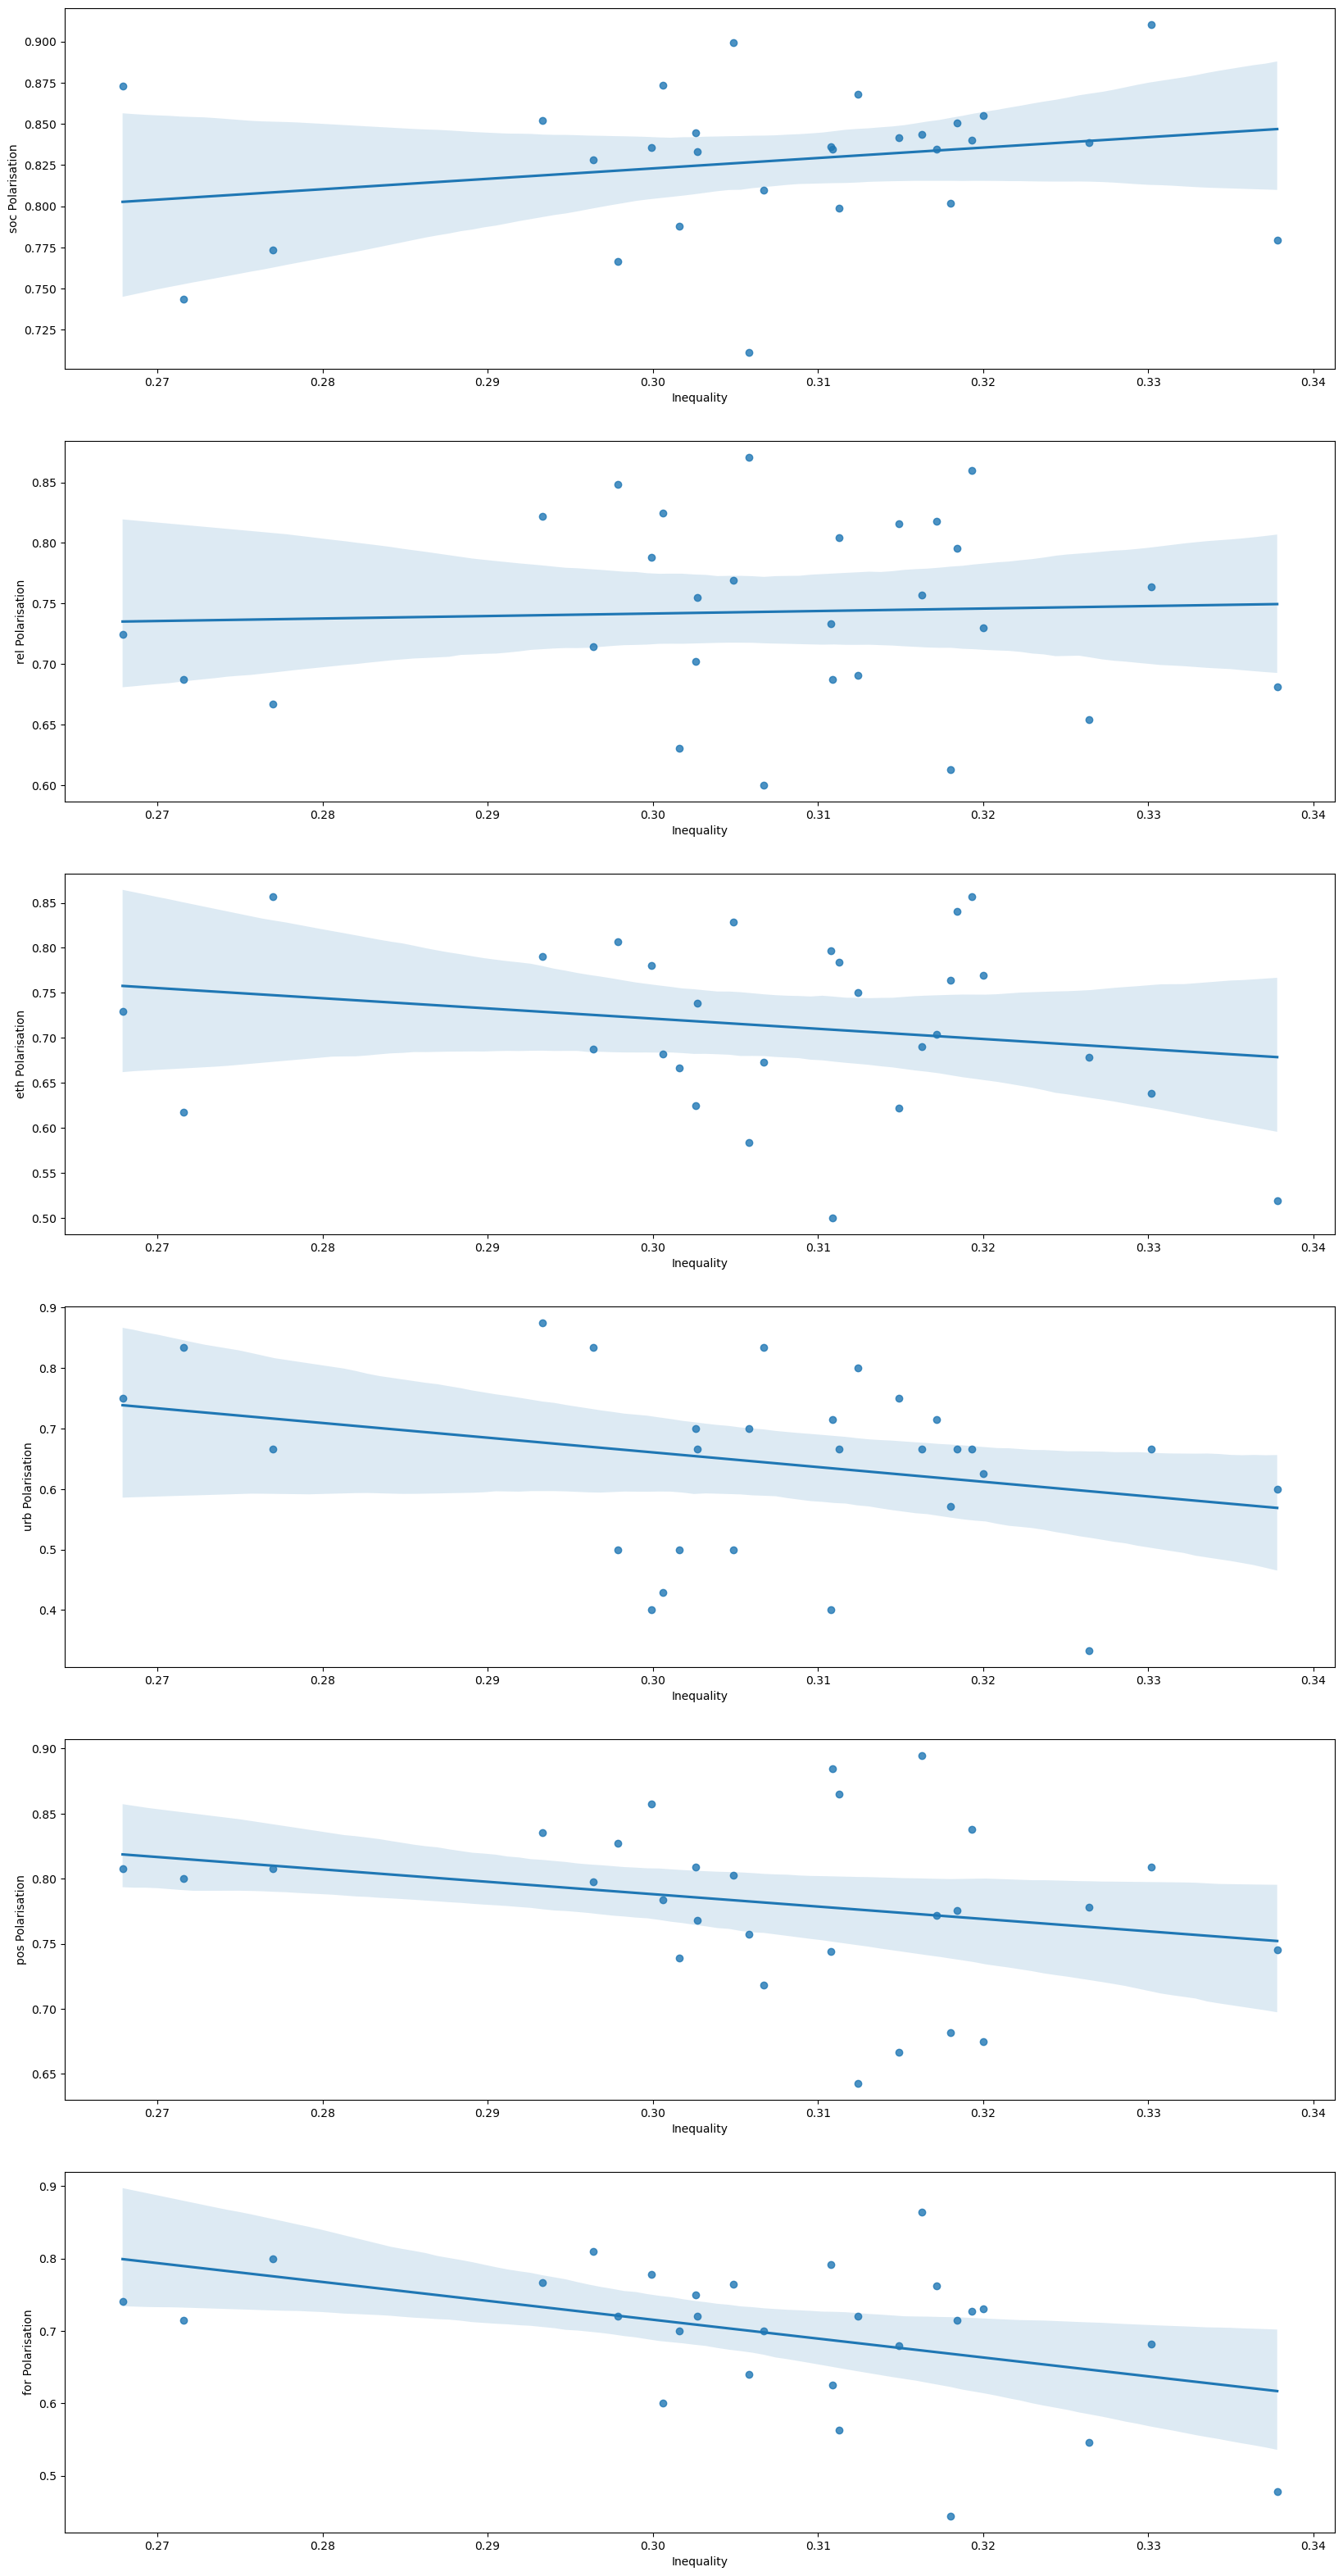

In [116]:
fig, ax = plt.subplots(6, 1, figsize = (20, 40))

for i, topic in enumerate(topic_list):
    sns.regplot(x = 'Inequality', y = topic + ' Polarisation', data = reg_df, ax = ax[i]);

In [117]:
x = reg_df['Inequality']
y = reg_df[topic + ' Polarisation']

x = sm.add_constant(x)

model = sm.OLS(y, x, missing = 'drop').fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:       for Polarisation   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     5.817
Date:                Thu, 27 Apr 2023   Prob (F-statistic):             0.0232
Time:                        16:48:40   Log-Likelihood:                 28.596
No. Observations:                  28   AIC:                            -53.19
Df Residuals:                      26   BIC:                            -50.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4979      0.332      4.508      0.0